# Big assignment 1

## Read before you start

* Provide clear and complete answers in code blocks or markdown. You may add as many as you need.
* Always motivate your answers. This can be done in markdown cells, or in comments in code.
* Submit your results via Brightspace. Use the following filename convention: ``StudentName1_snumber1_StudentName2_snumber2_LargeAssignment1.ipynb``.
* Make sure you submit a fully executed version of the notebook file. The teaching assistants will not run/debug your code during grading.
* Questions? Ask them during the workgroups, or see Brightspace for instructions on how to proceed.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pyjags as pj

print('Using PyJAGS v{:s}'.format(pj.__version__))

plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=12)       # legend fontsize
plt.rc('figure', titlesize=30)      # fontsize of the figure title

Using PyJAGS v1.3.8


# 1. Modelling exam results

In this exercise, we'll use some very small data sets and Bayesian modeling to answer some simple research questions. We'll study the performance of students on multiple choice exams (us teachers are obsessed with these type of examples). We'll be using `pyjags` to construct increasingly complex models for such data.

## 1.1. To study or not to study
Suppose we have an exam of $n = 40$ true-or-false questions, and $m = 15$ students that take this test. We observe the following scores on the exam:

$$
\mathbf{k} = (19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33) \enspace,
$$ where $k_i$ is the number of correct answers out of $n$ for student $i$.

If you look closely at these data, it seems as if it captures two different 'types' of students: one type performs reasonably well, whereas the other type reaches only guessing-level performance. 

It would be great if we could figure out to which type each student belongs, and what the success rates (i.e., the probabilities of a correct answer) are for the two groups.

The first steps to modelling this situation consists of writing down the generative model, and drawing the corresponding graphical model. The generative model should include (at least) the following:

- $k_i$: the number of questions answered correctly by student $i$.
- $z_i$: the group label for student $i$ (group 0: guessing; group 1: studying).
- $\theta_i$: the probability student $i$ answers correctly.
- $\psi$: the probability of a correct answer for students in group 0.
- $\phi$: the probability of a correct answer for students in group 1.

You may need to add several (hyper-)parameters yourself!

1. What distribution makes sense for the likelihood $P(k_i \mid n, \ldots)$?

We can imagine each student's exam performance as a coin-flip, i.e. either they get the question correct or not. Depending on the student, the probability of correct is higher or lower. We repeat this coin-flip for $n$ times, and observe the probability of $k$ trials being correct from $n$. This is best modelled by a binomial distribution, i.e. $P(k_i \mid n, \ldots) = f(k_i, n, \theta_i) = \binom{n}{k_i} \theta_i^{k_i}(1-\theta_i)^{n-k_i}$.

2. Write down the generative model for this scenario. Think carefully about:
  - Which variable do you want to learn?
  - Which variable do you want to set to a fixed value (a hyperparameter)?
  - Which variable is observed?
  - Which variables are deterministic transformations of other variables?

Here are two hints:

First, The probability of a correct answer depends on the group a student belongs to ($z_i$). To express this in a generative model, we can use $z_i$ as an _indexing variable_ (this is the same idea as the label variable in a mixture model; that is essentially what we have here!). For example, one could specify:

$$
  \theta_i = \begin{cases}\phi & \text{if $z_i=1$}\\ \psi &\text{if $z_i=0$.}\end{cases}
$$

Second, note that if a student is not in the guessing group, we expect them to perform __better__ than chance level.

\begin{align*}
% Priors
\pi &\sim \text{Beta}(1, 1) \\
\phi &\sim \text{Uniform}(0.5, 1) \\
\psi &= 0.5 \\


% Likelihood (loop over students)
\text{For } i &= 1, \ldots, m: \\
z_i &\sim \text{Bernoulli}(\pi) \\
\theta_i &= z_i \phi + (1-z_i)\psi \\
k_i &\sim \text{Binomial}(n, \theta_i)
\end{align*}


3. Draw the corresponding graphical model. Pay attention to: 
  - Which variable is observed (data or hyperparameter), 
  - Which is latent (these we want to learn), and
  - Which variables repeat.

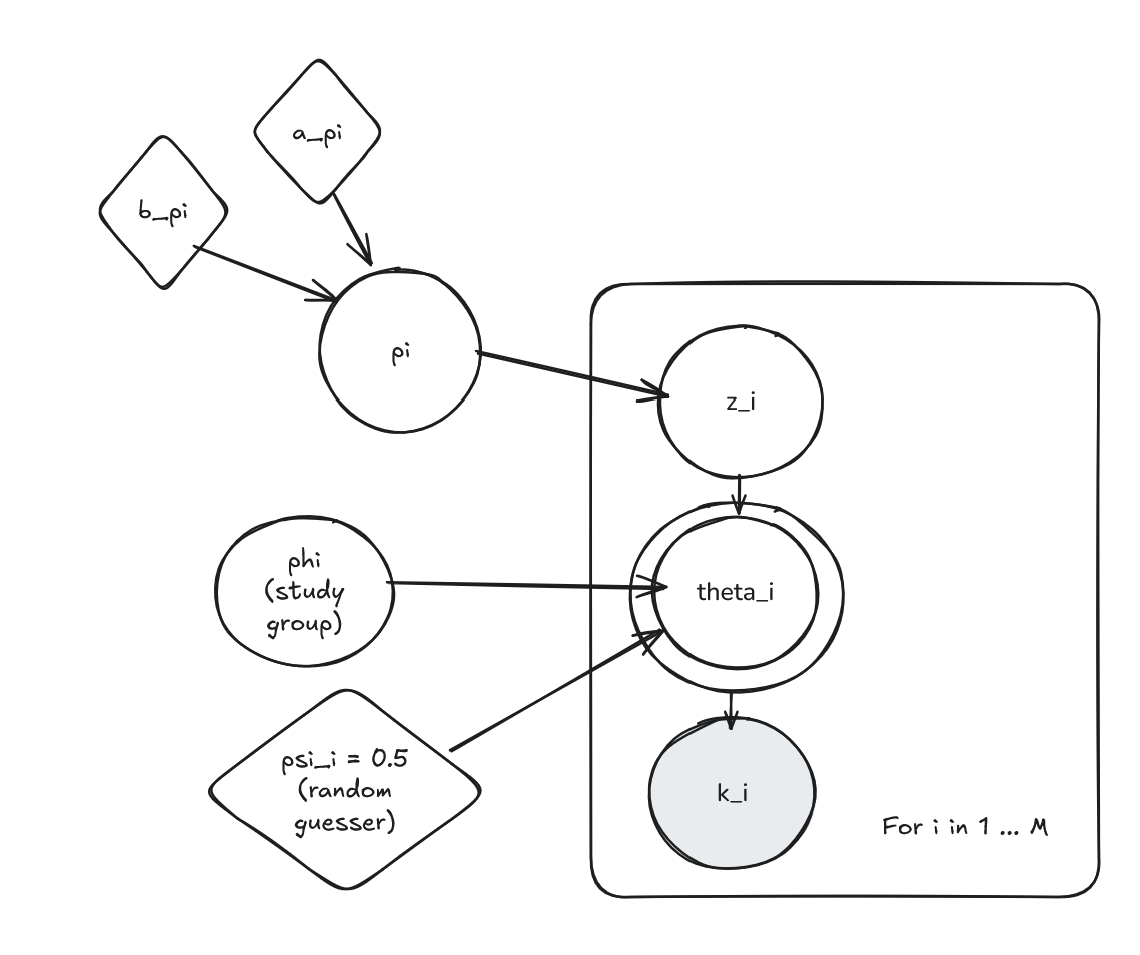

4. Write down the application of Bayes' theorem for your model. You do not need to solve the integral in the marginal likelihood; we'll avoid that by using JAGS. You may leave distributions in abstract notation, e.g. $p(k_i \mid n, \ldots)$; you do not have to write down their full expressions.

Let $\Theta = \{\pi, \phi, \mathbf{z}\}$ be the set of unknown parameters, where $\mathbf{z} = (z_1, \ldots, z_m)$. Let $\mathbf{k} = (k_1, \ldots, k_m)$ be the observed data. We also have known constants $n$ and $\psi=0.5$.

Prior $P(\Theta)$:
Assuming independence between $\phi$ and $\pi$, and conditional independence of $z_i$'s given $\pi$:
\begin{equation*}
P(\Theta) = P(\pi, \phi, \mathbf{z}) = P(\phi) \, P(\pi) \, P(\mathbf{z} \mid \pi) = P(\phi) \, P(\pi) \, \prod_{i=1}^{m} P(z_i \mid \pi)
\end{equation*}
For exact distributions, see earlier genreative model.

Likelihood $P(\mathbf{k} \mid \Theta)$:
Due to conditional independence of $k_i$'s given the parameters, and the fact that $k_i$ depends on $\pi$ only through $z_i$:
\begin{equation*}
P(\mathbf{k} \mid \Theta) = P(\mathbf{k} \mid \pi, \phi, \mathbf{z}) = P(\mathbf{k} \mid \phi, \mathbf{z}) = \prod_{i=1}^{m} P(k_i \mid \phi, z_i, n, \psi) = \prod_{i=1}^{m} P(k_i \mid n, \theta_i)
\end{equation*}

Here we see that $k_i$ only depends on $\pi$ if we don't know $z_i$, i.e. conditional independence. Therefore, once we know $z_i$ we can safely ignore it. Furthermore, once we know $\theta_i$, we can ignore $z_i$ and $\phi$ as well, as there is no further influence besides in $\theta_i$.

Marginal Likelihood $P(\mathbf{k})$:
For the marginal likelihood we can use the principle of total probability, i.e. first obtain the joint distribution of k and $\Theta$ and then marginalize out all parameters, to retrieve the data distribution (normalization constant/evidence).
\begin{equation*}
P(\mathbf{k}) = \int_{0.5}^{1} \int_{0}^{1} \sum_{\mathbf{z} \in \{0,1\}^m} P(\mathbf{k} \mid \phi, \mathbf{z}) P(\phi) P(\pi) P(\mathbf{z} \mid \pi) \, d\pi \, d\phi
\end{equation*}
Here we see that we simply do an intergral over all domains of the parameters, and then sum over $2^m$ possibilities (i.e. each student belonging to either group) the product of the likelihood and prior terms.

5. Do a so-called _prior predictive check_: Sample random values for the latent variables of your model (using the `numpy.random` module or with JAGS) and use them to generate a new vector $\hat{\mathbf{k}}$. Does it exhibit the properties you want it to have, when you compare it to the actual $\mathbf{k}$?

In [15]:
import numpy as np

num_tests = 10

for test in range(num_tests):
    print('Test number', test)
    pi = np.random.beta(1, 1, 1)
    print('pi =', pi)

    phi = np.random.uniform(0.5, 1, 1)
    print('phi =', phi)

    psy = 0.5

    k = []
    for i in range(15):
        z_i = np.random.binomial(1, pi, 1)
        theta_i = z_i*phi + (1-z_i)*psy
        k_i = np.random.binomial(40, theta_i, 1)
        k.append(k_i[0])
        
    actual_k = np.array([19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33])

    print('k =', k)
    print('actual_k =', actual_k)

Test number 0
pi = [0.46477831]
phi = [0.90276075]
k = [24, 19, 18, 23, 18, 19, 14, 35, 38, 18, 18, 39, 21, 33, 18]
actual_k = [19 20 16 23 22 30 38 29 34 35 35 32 37 36 33]
Test number 1
pi = [0.92494228]
phi = [0.51050557]
k = [15, 20, 19, 24, 26, 14, 21, 21, 17, 21, 16, 24, 25, 24, 21]
actual_k = [19 20 16 23 22 30 38 29 34 35 35 32 37 36 33]
Test number 2
pi = [0.41318126]
phi = [0.83880657]
k = [20, 15, 17, 37, 23, 20, 33, 21, 33, 20, 20, 21, 21, 35, 32]
actual_k = [19 20 16 23 22 30 38 29 34 35 35 32 37 36 33]
Test number 3
pi = [0.92648695]
phi = [0.95763943]
k = [20, 40, 40, 39, 37, 38, 36, 38, 40, 40, 39, 17, 39, 40, 40]
actual_k = [19 20 16 23 22 30 38 29 34 35 35 32 37 36 33]
Test number 4
pi = [0.12946431]
phi = [0.68445097]
k = [23, 19, 30, 16, 19, 24, 21, 18, 17, 19, 18, 25, 20, 20, 27]
actual_k = [19 20 16 23 22 30 38 29 34 35 35 32 37 36 33]
Test number 5
pi = [0.50078364]
phi = [0.57354096]
k = [24, 26, 26, 16, 21, 19, 24, 23, 17, 16, 21, 23, 18, 23, 20]
actual_k = [19

Comparing these simulated datasets to the actual observed scores (actual_k), we see that the priors generate data within a plausible range. Many of the simulated datasets (e.g., Tests 0, 4, 5, 9) exhibit the key characteristic of the observed data: a separation between scores near the guessing level (around 20) and higher scores. While the specific distributions vary based on the sampled pi and phi (sometimes producing mostly guessers, sometimes mostly high-scorers, sometimes a clear mix), the ability of the priors to generate data qualitatively similar to the real data seems like the prior distributions were correct.

6. Implement the model in JAGS and train it on the available data.

In [34]:
%%time 
n = 40
k = [19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33]
m = len(k)

jags_model = '''
model {
    pi ~ dbeta(1, 1)
    phi ~ dunif(0.5, 1)
    psy = 0.5
    
    for (i in 1:m) {
        z[i] ~ dbern(pi)
        theta[i] <- z[i]*phi + (1-z[i])*psy
        k[i] ~ dbin(theta[i], n)
    }
}
'''


data = {
    'k': k,
    'n': n,
    'm': len(k)
}

# How long we sample
num_iter = 30_000
# How many distinct sampling runs
num_chains = 4

model = pj.Model(jags_model, data=data, chains=num_chains)
samples = model.sample(num_iter, vars=['pi', 'phi', 'z', 'theta'])

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


sampling: iterations 120000 of 120000, elapsed 0:00:01, remaining 0:00:00
CPU times: user 969 ms, sys: 0 ns, total: 969 ms
Wall time: 967 ms


7. Use the code below to make a ridge plot of $\theta_i$. Adapt the code to also show the maximum likelihood estimates for $\theta_i$ as a red vertical line, for each student. Are the distributions for $\theta_i$ consistent with MLEs?

/tmp/ipykernel_1841/4040921846.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('inferno')


[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: xlabel='$\\theta$'>]

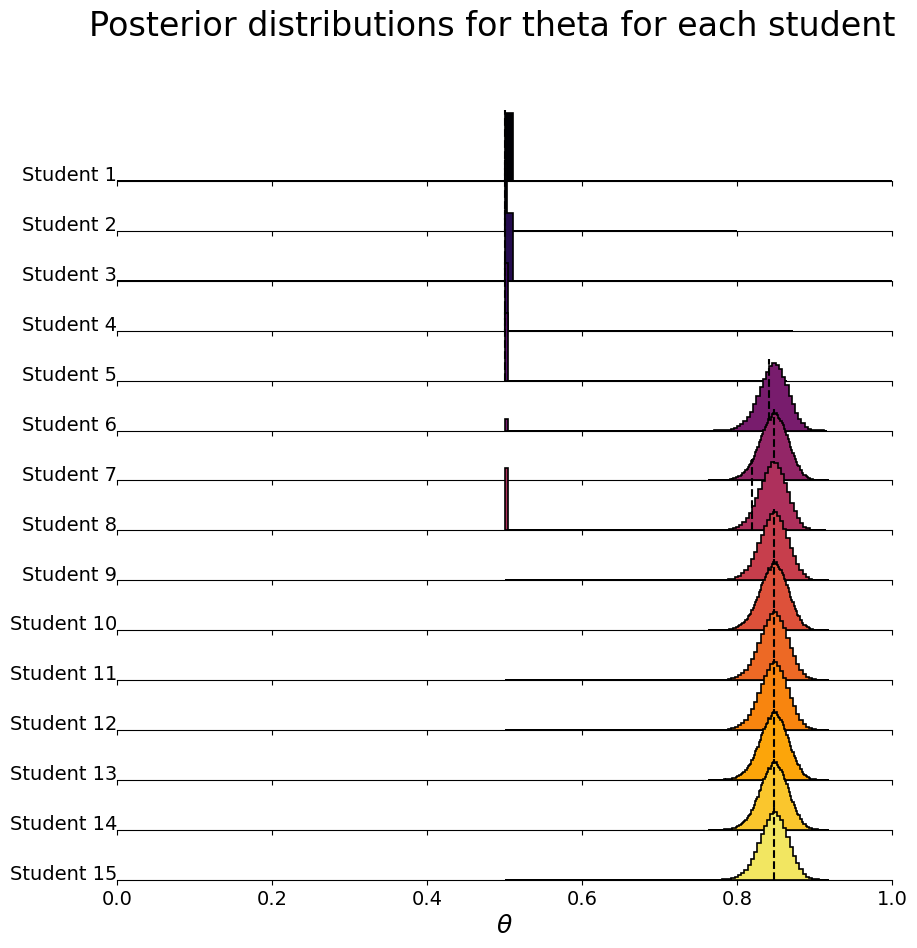

In [37]:
import matplotlib.gridspec as grid_spec
from scipy.stats import gaussian_kde

def ridge_plot(samples, xlimits, suptitle, xlabel, ylabel):
    """Make a ridge-plot figure.

    This function makes a ridge plot. It consists of a number of visually 
    overlapped smoothed histograms. 
    
    The dashed lines indicate the observed treatment effects, while the 
    histograms show what our model estimates.

    Args:
        samples: A numpy array of size m x num_samples x num_chains
        xlimits: the horizontal limits of the figures
        suptitle: the title to put above the figure
        xlabel: the name of the x-label
        ylabel: the name of each row
    """
    colors = plt.cm.get_cmap('inferno')
    J = samples.shape[0]
    gs = grid_spec.GridSpec(J, 1)
    fig = plt.figure(figsize=(10, 10))

    i = 0
    xmin, xmax = xlimits
    theta = np.linspace(xmin, xmax, num=200)    
    MLE_theta = np.mean(samples, axis=(1, 2))
    ax_objs = []
    for i in range(J):
        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].hist(samples[i, :, :].flatten(), density=True, bins=100,
                         histtype='stepfilled', edgecolor='k', linewidth=1.2, color=colors(i/J))
        ax_objs[-1].axvline(x=MLE_theta[i], color='k', linestyle='--', linewidth=1.5)
        # setting uniform x and y lims
        ax_objs[-1].set_xlim(xmin, xmax)
        ax_objs[-1].set_ylim(bottom=0)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])
        
        if i != J-1:
            ax_objs[-1].set_xticklabels([])            
        ax_objs[-1].text(xmin, 0.001, f'{ylabel} {i+1}',fontsize=14, ha="right")

        spines = ["top", "right", "left"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
        ax_objs[-1].set_yticks([])
        i += 1

    ax_objs[-1].set_xlabel(xlabel)
    gs.update(hspace=-0.3)
    plt.suptitle(suptitle, fontsize=24)    
    return ax_objs

#
ridge_plot(samples['theta'], (0, 1), "Posterior distributions for theta for each student",r"$\theta$", "Student")

8. What are the posterior probabilities that a student has studied, for each of the $m$ students?

In [47]:
z = samples['z'].mean(axis=(1, 2))
formatted_z = [f"{prob:.2f}" for prob in z]
print(f"Posterior P(z_i=1|k): {formatted_z}")

Posterior P(z_i=1|k): ['0.00', '0.00', '0.00', '0.00', '0.00', '0.98', '1.00', '0.92', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']


## 1.2. Individual variability

The previous model makes a strong assumption: students that did study, all have the _same_ probability of answering a question correctly. That does not seem very realistic. 

1. Alter your generative model and your JAGS implementation to capture differences in performance among students that _did_ study. Make explicit what you changed compared to the previous model! In addition, make another ridge plot to show your updated results.

In [18]:
%%time 
n = 40
k = [19, 20, 16, 23, 22, 30, 38, 29, 34, 35, 35, 32, 37, 36, 33]
m = len(k)

jags_model2 = '''
model {

}
'''


data = ...

# How long we sample
num_iter = ...
# How many distinct sampling runs
num_chains = ...

model2 = pj.Model(jags_model2, data=data, chains=num_chains)
samples2 = model2.sample(num_iter, vars=[...])

JagsError: 
Error parsing model file:
syntax error on line 4 near "}"


2. Now print again the probabilities that each individual student has studied; print both the probability according to your first model and according to your second model. 



You should see that some probabilities have changed.

3. Why did adding the individual variability to the probability of a correct answer after studying, change the probability for students who performed poorly?

## 1.3. Easy and tough exam questions

The previous model assumed that all questions were equal in difficulty. Of course, this is rarely the case in practice. Here, we construct a new model in which we represent both _student ability_ and _question difficulty_. 

To be able to model the difficulty of questions, we will not work with the aggregate results of the test (that is, the number of questions correct, previously $k_i$), but with the results for the individual questions. Now, $k_{ij}=1$ indicates that student $i$ answered question $j$ correctly. We will assume the probability of a question being answered correctly can be written as

$$
    \theta_{ij} = p_i q_j \enspace,
$$ 

in which $p_i$ is the probability student $i$ answers a question correctly, and $q_j$ is the probability question $j$ gets answered correctly. As you can see, even a student who is very smart ($p_i\approx 1$) might not answer correctly if a question is very difficult ($q_j\approx 0$).

Below are the results (observations) for $m=10$ students making $n=20$ questions.

In [19]:
k = np.array([[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0 ],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],              
              [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],              
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

m, n = k.shape

1. Construct a generative model by which we can learn the individual student performances $p_i$ as well as the question difficulties $q_j$.

2. Implement your model in JAGS. Visualize the posterior estimates of each $p_i$ and $q_j$ in a way you think is appropriate.

In [20]:
%%time 

jags_model3 = '''
model {
   
}
'''

data = ...

# How long we sample
num_iter = ...
# How many distinct sampling runs
num_chains = ...

model3 = pj.Model(jags_model3, data=data, chains=num_chains)
samples3 = model3.sample(num_iter, vars=[...])

JagsError: 
Error parsing model file:
syntax error on line 4 near "}"


3. According to your model, which students performed best, and which questions where the most difficult?

Tip: for this 'sorting', it might be easiest to compute for each $p_i$ or $q_j$ the _mode_ of the distribution and sort according to this.

---
# 2. Let's milk this further with Bayesian regression

In an attempt to produce productivity, farmer Fred decides to start cuddling his cows for a testing period of one month. For each cow, Fred writes down the number of cuddles she received ($x_i$) as well as the total amount of milk they produced that month ($y_i$; in liters).

The following code snippet loads and visualizes Fred's data set.

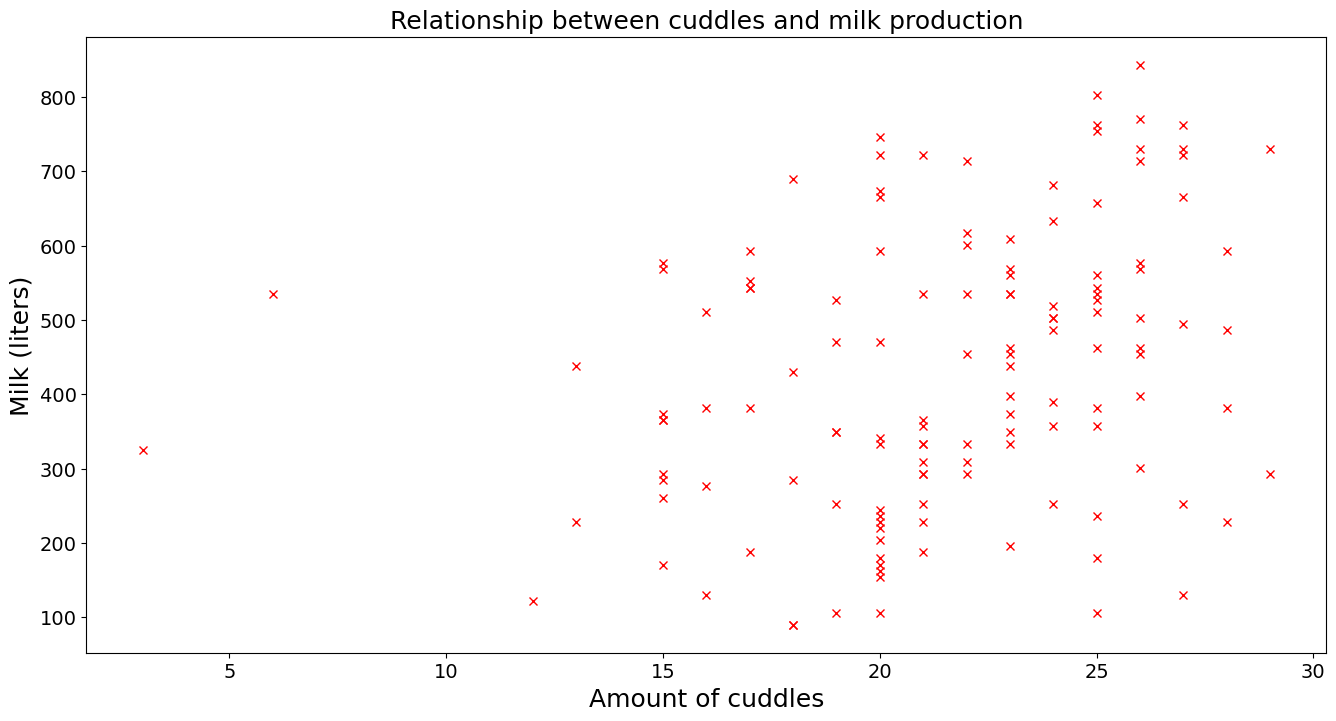

In [21]:
import pandas as pd

df = pd.read_csv('cow_cuddles_fred.csv', delimiter=';', decimal=',', header=None)
x = df[0].to_numpy()
y = df[1].to_numpy()
n = len(y)


plt.figure(figsize=(16, 8))
plt.plot(x, y, 'rx')
plt.xlabel('Amount of cuddles')
plt.ylabel('Milk (liters)')
plt.title('Relationship between cuddles and milk production');

1. Implement a Bayesian linear regression model in JAGS.

In [22]:
%%time

code = '''
model{      
 
}
'''

data = ...
num_samples = ...
num_chains = ...

m = pj.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=[...])

JagsError: 
Error parsing model file:
syntax error on line 4 near "}"


2. Use your MCMC samples to visualize the posterior distribution of $\mu=w_0+w_1 x$ for a range of $x$, e.g., `x_plot = np.linspace(0, 30, num=100)`, by showing the posterior expectation and the 95% HDI (see Lecture 6). 

Tip: To construct the posterior of $\mu$, you will need the samples of the regression weights ($w_0$ and $w_1$). You could, for every MCMC sample $s$, take $w_0^{(s)}$ and $w_1^{(s)}$ and construct the vector $\mathbf{\mu}^{(s)}$ for each (this vector is of length 100, as `x` was constructed to have that length). However, doing this in a `for` loop can be very slow! It is much faster (i.e., more than 100 times) to add/multiply entire `numpy` matrices/arrays at once.

In [23]:
plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.plot(x, y, 'rx', label='Observations')

m = 100
x_plot = np.linspace(0, 30, num=m)
w0_samples = ...
w1_samples = ...

x_repeat = np.repeat(x_plot[:, np.newaxis], num_samples*num_chains, axis=1).T
w0_repeat = ... # its shape should be (num_samples*num_chains, m)
w1_repeat = ... # its shape should be (num_samples*num_chains, m)

mu_samples = w0_repeat + w1_repeat*x_repeat

mu_exp = # get the posterior expectation of mu
mu_lower = # get the lower limit of the 95% HDI
mu_upper = # get the upper limit of the 95% HDI

ax.plot(x_plot, mu_exp, color='tab:green', 
        label=r'Expectation of $\mu_i = w_0 + w_1x_i$')
ax.fill_between(x_plot, 
                mu_lower,
                mu_upper, color='tab:green', alpha=0.3, label='95% HDI')
ax.legend()
plt.xlabel('Amount of cuddles')
plt.ylabel('Milk (liters)')
plt.title('Relationship between cuddles and milk production')
ax.set_xlim([x_plot[0], x_plot[-1]]);

SyntaxError: invalid syntax (3185798009.py, line 16)

---
__IMPORTANT__

Something we have not discussed at length is the relationship between our priors and the _scale_ of the data. If you have used a fairly standard prior for your regression weights, such as $w_1 \sim \text{Gaussian}(0, 1)$, you are saying in your prior that you expect only _small_ changes to the amount of milk as a function of an increase in number of cuddles. However, the amount of milk is measured in _hundreds_ of liters. If there indeed is an effect, that means that $w_1$ could have a true value such as 20 (for every additional cuddle, 20 more liters produced) -- which is extremely unlikely under the $\text{Gaussian}(0, 1)$ prior. 

The result of such a 'wrong' prior specification can be that the model learns there is almost no effect, and that all observations are just explained by a (nearly) horizontal regression line and a large measurement noise $\sigma$ (the standard deviation of the Gaussian likelihood).

If this happens in your analysis, you have used a prior that is too restrictive (or we simply don't have enough data). It is easily fixed; just make your priors _wider_. For example, use $\text{Gaussian}(0, \sigma=10)$ instead (remember that in JAGS that would be `dnorm(0, 1/pow(10,2))`.

Make sure your posterior expectation of the regression looks reasonable before proceeding!

---

3. Make a histogram of the posterior of the standard deviation $\sigma$. Does it show reasonable values compared to your previous figure (for example, at $x=20$, our observations range from roughly 80 to 750; our standard deviation therefore should not be 4, or 2000)?

In [ ]:
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.hist(..., density=True, bins=100, 
        label=r'Posterior $p(\sigma \mid x_1, \ldots, x_n)$')
ax.legend()
ax.set_title('Posterior of the observation noise');

The previous questions asked you to visualize the posterior distributions of the vector $\mu$ and the scalar $\sigma$. But to know what happens when Fred cuddles a new cow for 40 times ($x^*=40$), we need the _posterior predictive_ distribution instead.

4. Plot a histogram of the (approximated) posterior predictive distribution: $p(y^* \mid x^*, x_1, \ldots, x_n)=\int p(y^* \mid w_0, w_1, \sigma, x^*)p(w_0, w_1, \sigma \mid x_1, \ldots, x_n) \text{d}w_0 \text{d}w_1 \text{d}\sigma$. In the same figure, plot another histogram (with a different color) of $\mu^*$, and a vertical line (using `axvline`) with the posterior expectation of $\mu^*$.

In [ ]:
x_pred = 40

y_pred = np.random.normal(loc=..., scale=...)

plt.figure(figsize=(16,8))
ax = plt.gca()
ax.hist(y_pred, density=True, bins=100, 
        label='Posterior predictive $p(y^* \mid x^*, x_1, \ldots, x_n)$')
ax.hist(..., density=True, bins=100, alpha=0.3, color='tab:green',
        label=r'Posterior $p(\mu^* \mid x^*, x_1, \ldots, x_n)$')
ax.axvline(x=..., color='tab:green', 
           label=r'Posterior expectation $\mathbb{E}\left[p(\mu^* \mid x^*, x_1, \ldots, x_n)\right]$')
ax.legend(fontsize=16)
ax.set_title('Posterior predictive');

Neighbouring farmer Francesco learns of Fred's results and decides to start cuddling her cows as well. She follows a similar procedure, and below you can see her observations.

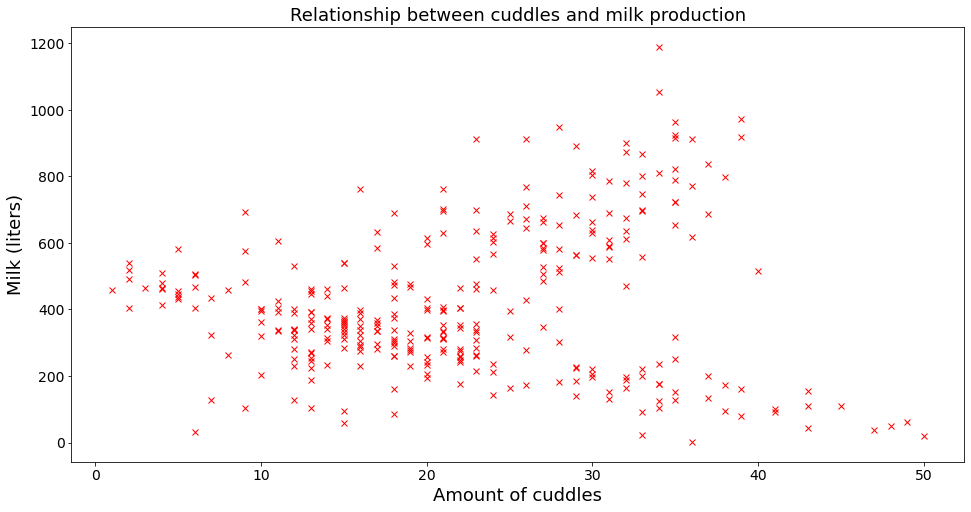

In [ ]:
import pandas as pd

df = pd.read_csv('cow_cuddles_francesca.csv', delimiter=';', decimal='.', header=None)
x = df[0].to_numpy()
y = df[1].to_numpy()
n = len(y)

plt.figure(figsize=(16, 8))
plt.plot(x, y, 'rx')
plt.xlabel('Amount of cuddles')
plt.ylabel('Milk (liters)')
plt.title('Relationship between cuddles and milk production');

Remarkably, the effect is a lot less clear than it was for Fred. In fact, it seems like there are two trends occurring in parallel: one group of cows benefits from cuddles, just like with Fred, but another group of cows seems to produce _less_ milk after receiving cuddles. Perhaps these are a different breed that are not so appreciative of hugging people?

5. Anyway, demonstrate that modelling these data with your Bayesian linear regression model leads to poor predictions, by showing the actual observations at $x=35$ and the posterior predictive distribution.

In [ ]:
%%time

code = '''
model{      
       
}
'''

data = ...
num_samples = ...
num_chains = ...

m = pj.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=[...])

To better model these observations, we need a _mixture model_. However, instead of a Gaussian mixture model like in the lecture, we now need a Bayesian linear regression mixture model.

6. Write down the generative model for the Bayesian linear regression mixture model. You may assume there are $K=2$ components.

7. Implement your model in JAGS. Make sure to consider the tips in Lecture 6 on keeping the components identifiable!

__Note__: As mentioned in the lecture, this model can take quite a bit longer to sample. My solution took about a minute on a Google colab environment.

In [ ]:
%%time

code = '''
model{      
    
}
'''

data = ...
num_samples = ...
num_chains = ...

m = pj.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=[...])

8. Visualize once more the posterior distribution of $\mu$ (expectation + 95% HDI), for `x_plot = np.linspace(0, 50, num=100)`. This time however, the plot should show two distinct $\mu$'s (and their 95% HDI); one for each mixture component.

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.plot(x, y, 'rx', label='Observations')

m = 100
x_range = np.linspace(0, 50, num=m)

...

colors = ['tab:green', 'tab:orange']

for k in range(2):
    ...
    ax.plot(x_range, ..., color=colors[k], 
            label=f'Expectation of component {k+1}')
    ax.fill_between(x_range, 
                    mu_lower,
                    mu_upper, color=colors[k], alpha=0.3, 
                    label=f'95% HDI of component {k+1}')

ax.legend()
ax.set_xlabel('Amount of cuddles')
ax.set_ylabel('Milk (liters)')
ax.set_title('Relationship between cuddles and milk production')
ax.set_xlim([x_range[0], x_range[-1]]);

9. Show the posterior predictive distribution for $x^*=35$. Explain the differences in this figure compared to your result for subquestion 4.

Tip: Simply showing the two posterior predictives for the two regressions is not sufficient. That would show two separate posterior predictive distributions, instead of one single distribution (i.e., it would integrate to 2 instead of 1 -- see the lecture slides). Instead, for each predictive sample $y^{(s)}$ you first need to sample $z^{(s)} \sim \text{Categorical}({\pi})$, where $\pi$ is the posterior probability that a point belongs to either component 1 or component 2. Then, once you know the label of the sampled point, you can take the appropriate $w_0$, $w_1$ and $\sigma$ to predict. Repeat this for all samples, and you collect the histogram of $p(y^* \mid x^*, x_1, \ldots, x_n)$.

In [ ]:
%%time 
x_pred = 35

mu_samples = ...
sigma_samples = ...
pi_samples = ...


y_pred = np.empty((num_chains*num_samples, ))

for j in range(num_samples*num_chains):    
    z_j = np.random.binomial(n=1, p=pi_samples[1, j], size=1)
    
    y_pred[j] = np.random.normal(loc=..., scale=...)


plt.figure(figsize=(16,8))
ax = plt.gca()
ax.hist(y_pred, density=True, bins=100, 
        label='Posterior predictive $p(y^* \mid x^*=35, x_1, \ldots, x_n)$')
ax.hist(y[x==x_pred], density=True, bins=100, alpha=0.3, color='tab:green',
        label=r'Observations at $x={:d}$'.format(x_pred))
ax.legend(fontsize=16)
ax.set_title('Posterior predictive');